In [74]:
import os
import re
import pickle
import string

from keras.layers import Input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

# 0. DATASET
- Flickr8k dataset
> Dataset Description 은 다음과 같습니다.     

```
If you use this corpus / data:

Please cite: M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artifical Intellegence Research, Volume 47, pages 853-899
http://www.jair.org/papers/paper3994.html


Captions, Dataset Splits, and Human Annotations :


Flickr8k.token.txt - the raw captions of the Flickr8k Dataset . The first column is the ID of the caption which is "image address # caption number"

Flickr8k.lemma.txt - the lemmatized version of the above captions 

Flickr_8k.trainImages.txt - The training images used in our experiments
Flickr_8k.devImages.txt - The development/validation images used in our experiments
Flickr_8k.testImages.txt - The test images used in our experiments


ExpertAnnotations.txt is the expert judgments.  The first two columns are the image and caption IDs.  Caption IDs are <image file name>#<0-4>.  The next three columns are the expert judgments for that image-caption pair.  Scores range from 1 to 4, with a 1 indicating that the caption does not describe the image at all, a 2 indicating the caption describes minor aspects of the image but does not describe the image, a 3 indicating that the caption almost describes the image with minor mistakes, and a 4 indicating that the caption describes the image.
```

# 1. EDA

### 1. 사진 샘플

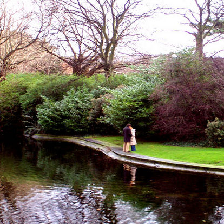

In [2]:
image = load_img('./Flicker8k_Dataset/3637013_c675de7705.jpg', target_size=(224, 224))
image

### 2. 사진 -> numpy array

In [3]:
image = img_to_array(image)
print(image.shape)
print(image)

(224, 224, 3)
[[[241. 247. 247.]
  [255. 252. 255.]
  [205. 205. 207.]
  ...
  [165. 149. 178.]
  [232. 222. 246.]
  [239. 240. 234.]]

 [[229. 238. 237.]
  [252. 247. 253.]
  [255. 255. 255.]
  ...
  [255. 252. 255.]
  [213. 209. 226.]
  [254. 255. 255.]]

 [[254. 255. 255.]
  [249. 238. 246.]
  [212. 206. 210.]
  ...
  [248. 242. 255.]
  [162. 156. 182.]
  [231. 230. 236.]]

 ...

 [[117.  97. 109.]
  [ 36.  14.  27.]
  [ 76.  37.  40.]
  ...
  [199. 195. 220.]
  [203. 190. 216.]
  [198. 184. 209.]]

 [[130. 119. 125.]
  [133. 106. 137.]
  [ 60.  26.  53.]
  ...
  [196. 180. 209.]
  [177. 167. 194.]
  [213. 211. 233.]]

 [[149. 120. 124.]
  [138. 111. 126.]
  [126. 115. 131.]
  ...
  [152. 143. 170.]
  [180. 174. 200.]
  [204. 196. 220.]]]


### 3. VGG16

In [4]:
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image.shape

(1, 224, 224, 3)

In [5]:
image = preprocess_input(image)
image

array([[[[ 143.061    ,  130.22101  ,  117.32     ],
         [ 151.061    ,  135.22101  ,  131.32     ],
         [ 103.061    ,   88.221    ,   81.32     ],
         ...,
         [  74.061    ,   32.221    ,   41.32     ],
         [ 142.061    ,  105.221    ,  108.32     ],
         [ 130.061    ,  123.221    ,  115.32     ]],

        [[ 133.061    ,  121.221    ,  105.32     ],
         [ 149.061    ,  130.22101  ,  128.32     ],
         [ 151.061    ,  138.22101  ,  131.32     ],
         ...,
         [ 151.061    ,  135.22101  ,  131.32     ],
         [ 122.061    ,   92.221    ,   89.32     ],
         [ 151.061    ,  138.22101  ,  130.32     ]],

        [[ 151.061    ,  138.22101  ,  130.32     ],
         [ 142.061    ,  121.221    ,  125.32     ],
         [ 106.061    ,   89.221    ,   88.32     ],
         ...,
         [ 151.061    ,  125.221    ,  124.32     ],
         [  78.061    ,   39.221    ,   38.32     ],
         [ 132.061    ,  113.221    ,  107.32     ]],

### 4. image load function
- load
- to array
- ready data for VGG16

- `read_text` 를 통해 파일 제목들을 읽습니다.
- `load_pics` 에 위에서 읽은 파일 제목들을 입력으로 넣고, image_filename: preprocess 된 image 형식의 dictionary 를 준비합니다
- Image Feature Extraction 을 위해서 VGG16 을 사용합니다.

In [6]:
def read_text(drt, file_name):
    with open(os.path.join(drt, file_name), 'r') as f:
        lines = f.read().splitlines()
    return lines

In [9]:
train_image_filenames = read_text('Flickr8k_text', 'Flickr_8k.trainImages.txt')
test_image_filenames = read_text('Flickr8k_text', 'Flickr_8k.testImages.txt')
print(len(train_image_filename))
print(len(test_image_filename))

6000
1000


In [10]:
def load_pics(directory, filenames):
    images = dict()
    input_layer = Input(shape=(224, 224, 3))
    model = VGG16(include_top=True, input_tensor=input_layer, weights='imagenet')
    for filename in filenames:
        image = load_img(os.path.join(directory, filename), target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        image = model.predict(image)
        images[filename] = image
    return images

In [11]:
train_images_features = load_pics('Flicker8k_Dataset', train_image_filenames)
f = open('train_images_features.pkl', 'ab') 
pickle.dump(train_images_features, f)
f.close()
# dump(train_images_features, open('train_imagesfeatures.pkl', 'wb'))

In [12]:
test_images_features = load_pics('Flicker8k_Dataset', test_image_filenames)
f = open('test_images_features.pkl', 'ab') 
pickle.dump(test_images_features, f)
f.close()
# dump(train_images_features, open('train_imagesfeatures.pkl', 'wb'))

In [100]:
list(train_images_features.keys())[:5]

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg']

In [51]:
train_images = load_pics('Flicker8k_Dataset', train_image_filename)
train_images

{'2513260012_03d33305cf.jpg': array([[[[ -54.939003,  -66.779   ,  -59.68    ],
          [ -87.939   ,  -88.779   ,  -95.68    ],
          [ -91.939   ,  -95.779   ,  -98.68    ],
          ...,
          [ -59.939003,  -71.779   ,  -68.68    ],
          [ -99.939   , -100.779   , -101.68    ],
          [ -56.939003,  -60.779   ,  -63.68    ]],
 
         [[ -57.939003,  -66.779   ,  -44.68    ],
          [ -41.939003,  -45.779   ,  -48.68    ],
          [ -85.939   ,  -95.779   ,  -94.68    ],
          ...,
          [ -67.939   ,  -71.779   ,  -65.68    ],
          [ -79.939   ,  -85.779   ,  -73.68    ],
          [ -82.939   ,  -87.779   ,  -87.68    ]],
 
         [[ -85.939   ,  -88.779   ,  -88.68    ],
          [ -88.939   ,  -91.779   ,  -91.68    ],
          [ -61.939003,  -67.779   ,  -65.68    ],
          ...,
          [ -72.939   ,  -77.779   ,  -77.68    ],
          [ -59.939003,  -61.779   ,  -60.68    ],
          [ -66.939   ,  -65.779   ,  -66.68    ]],
 

### 5. Text (Image Description)
- 한 이미지당 #0 #1 #2 #3 #4  5개의 Description 이 있는 것을 확인 할 수 있습니다.

In [87]:
description_text = read_text('Flickr8k_text', 'Flickr8k.token.txt')
print("length: ", len(description_text))

length:  40460


In [88]:
#6개 이상의 description 이 있다면, 확인하는 코드
pattern = re.compile('.*jpg#5')
for text in description_text:
    answer = pattern.match(text)
    if answer:
        print("There are more than 5 descriptions in image")
        break

In [89]:
description_text[0].split('\t')[0].split('#')

['1000268201_693b08cb0e.jpg', '0']

In [90]:
description_text[0].split('\t')[1]

'A child in a pink dress is climbing up a set of stairs in an entry way .'

In [91]:
def id_description(description_text):
    descriptions = {}
    for description in description_text:
        img_id = description.split('\t')[0].split('#')[0]
        img_description = description.split('\t')[1]
        if img_id not in descriptions:
            descriptions[img_id] = img_description
    return descriptions

In [92]:
image_descriptions_dict = id_description(description_text)

In [93]:
list(image_descriptions_dict.items())[:5]

[('1000268201_693b08cb0e.jpg',
  'A child in a pink dress is climbing up a set of stairs in an entry way .'),
 ('1001773457_577c3a7d70.jpg', 'A black dog and a spotted dog are fighting'),
 ('1002674143_1b742ab4b8.jpg',
  'A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .'),
 ('1003163366_44323f5815.jpg',
  'A man lays on a bench while his dog sits by him .'),
 ('1007129816_e794419615.jpg',
  'A man in an orange hat starring at something .')]

In [94]:
print("description 갯수: ", len(image_descriptions_dict))

description 갯수:  8092


#### Make lowercase

In [95]:
for img_id, img_description in image_descriptions_dict.items():
    image_descriptions_dict[img_id] = img_description.lower()

In [96]:
list(image_descriptions_dict.items())[:5]

[('1000268201_693b08cb0e.jpg',
  'a child in a pink dress is climbing up a set of stairs in an entry way .'),
 ('1001773457_577c3a7d70.jpg', 'a black dog and a spotted dog are fighting'),
 ('1002674143_1b742ab4b8.jpg',
  'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .'),
 ('1003163366_44323f5815.jpg',
  'a man lays on a bench while his dog sits by him .'),
 ('1007129816_e794419615.jpg',
  'a man in an orange hat starring at something .')]

#### Remove Punctuation


In [97]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [98]:
for img_id, img_description in image_descriptions_dict.items():
    split_description = img_description.split()
    temp_description = []
    for word in split_description:
        if word not in string.punctuation:
            temp_description.append(word)
    image_descriptions_dict[img_id] = ' '.join(temp_description)

In [99]:
list(image_descriptions_dict.items())[:5]

[('1000268201_693b08cb0e.jpg',
  'a child in a pink dress is climbing up a set of stairs in an entry way'),
 ('1001773457_577c3a7d70.jpg', 'a black dog and a spotted dog are fighting'),
 ('1002674143_1b742ab4b8.jpg',
  'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl'),
 ('1003163366_44323f5815.jpg',
  'a man lays on a bench while his dog sits by him'),
 ('1007129816_e794419615.jpg', 'a man in an orange hat starring at something')]